In [1]:
import cv2

In [2]:
import cv2
import numpy as np
import math
import typing
import os
def show(frame):
    cv2.imshow("test", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def plot_point(frame,x,y,color=(0,255,0)):
    radius = 2
    thickness = -1
    #print(np.min(frame),np.max(frame),frame.shape,type(frame))
    return cv2.circle(frame, (x,y), radius, color, thickness)
def plot_line(frame,p1,p2,color=(0,191,255)):
    thickness = 2
    return cv2.line(frame, (p1[0],p1[1]), (p2[0],p2[1]), color, thickness)
def getIdealPointGroup(points):
  pointGroups = []
  index = 0
  subgroup = [points[0]]

  for i in range(len(points) - 1):
    prevPoint = points[i]
    currentPoint = points[i+1]

    if (abs(int(prevPoint[0])-int(currentPoint[0])) <= 1) and (abs(int(prevPoint[1])-int(currentPoint[1])) <= 1):
      subgroup.append(currentPoint)
    else:
      pointGroups.append(subgroup[:])
      subgroup = [currentPoint]

  pointGroups.append(subgroup)

  mainPointGroup = []
  maxPointGroupSize = 0

  for group in pointGroups:
    if len(group) > maxPointGroupSize:
      maxPointGroup = group
      maxPointGroupSize = len(group)

  return maxPointGroup

# Gets all the contours for certain image
  

def get_bottom_left(points,img,index = None):
  if not index is None:
    i = int(index*len(points))
    return points[i], index 
  max_y = len(img[0])
  index = 0
  dist = 100000
  count = 0
  for i in points:
    if (i[0])**2+(max_y-i[1])**2<dist:
      index = count
      dist = (i[0])**2+(max_y-i[1])**2
    count+=1
  return points[index],index/len(points)

def loadvideo(filename: str) -> np.ndarray:
    """Loads a video from a file.

    Args:
        filename (str): filename of video

    Returns:
        A np.ndarray with dimensions (channels=3, frames, height, width). The
        values will be uint8's ranging from 0 to 255.

    Raises:
        FileNotFoundError: Could not find `filename`
        ValueError: An error occurred while reading the video
    """

    if not os.path.exists(filename):
        raise FileNotFoundError(filename)
    capture = cv2.VideoCapture(filename)

    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = 224#int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    v = np.zeros((frame_count, frame_height,frame_width, 3), np.uint8)

    for count in range(frame_count):
        ret, frame = capture.read()
        if not ret:
            raise ValueError("Failed to load frame #{} of {}.".format(count, filename))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        v[count] = frame

    v = v.transpose((3, 0, 1, 2))

    return v
def savevideo(filename: str, array: np.ndarray, fps: typing.Union[float, int] = 1):
    """Saves a video to a file.

    Args:
        filename (str): filename of video
        array (np.ndarray): video of uint8's with shape (channels=3, frames, height, width)
        fps (float or int): frames per second

    Returns:
        None
    """

    c, f, height, width = array.shape

    if c != 3:
        raise ValueError("savevideo expects array of shape (channels=3, frames, height, width), got shape ({})".format(", ".join(map(str, array.shape))))
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for i in range(f):
        out.write(array[:, i, :, :].transpose((1, 2, 0)))

        
def obtainContourPoints(img,iterations = 1):
  # read image

  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # set lower and upper bounds on blue color
  lower = (250,0,0)
  upper = (255,200,200)

  # threshold and invert so hexagon is white on black background
  thresh = cv2.inRange(rgb, lower, upper)
  
  #print(np.min(thresh),np.max(thresh),thresh.shape)

  # show(thresh)
  # get contours
  result = np.zeros_like(thresh)
  im2, contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  thresh = cv2.dilate(thresh, None, iterations=iterations)
  #thresh = np.array([thresh,thresh,thresh])
  #thresh = np.transpose(thresh,(1,2,0))
  spare = thresh
  thresh = thresh==255

  img[thresh]=[255,255,255]

  #cv2.drawContours(img, im2, -1, (0,255,0), 3)

  im2 = np.array(im2)
  index_1 = 0
  index_2 = 0
  for i in im2:
    if i.shape[0]>im2[index_1].shape[0]:
      index_1=index_2
    index_2+=1
  rec = cv2.minAreaRect(im2[index_1])
  color = (0, 0, 255) 
  thickness = 2
  box = cv2.boxPoints(rec)
  box = np.int0(box)
  indexes = [0,1]
  for i in range(0,len(box)):
    for k in range(0,len(indexes)):
      if box[i][1]>box[indexes[k]][1] and not i in indexes:
        indexes[k]=i

  # cv2.drawContours(img,[box],0,(191,0,255),2)
  #thresh = plot_line(img,box[indexes[0]],box[indexes[1]])
  #print(np.min(thresh),np.max(thresh),thresh.shape,type(thresh))
  #print(np.min(img),np.max(img),img.shape,type(img))
  #print(iterations,box[indexes[0],1],box[indexes[0],0],spare[box[indexes[0],1],box[indexes[0],0]],box[indexes[1],1],box[indexes[1],0],spare[box[indexes[1],1],box[indexes[1],0]])
  img = plot_point(img,box[indexes[0],0],box[indexes[0],1])
  img = plot_point(img,box[indexes[1],0],box[indexes[1],1])
  #cv2.rectangle(img,rec,color,thickness)
  #show(img)
  x1 = min(box[indexes[0],1],111)
  y1 = min(box[indexes[0],0],111)
  x2 = min(box[indexes[1],1],111)
  y2 = min(box[indexes[1],0],111)
  pair = (not thresh[x1,y1]) or (not thresh[x2,y2])
  return img,thresh, x1,y1,x2,y2, pair

In [3]:
key_points = []
from tqdm import tqdm
folder = 'C:\\Users\\TheurerJ\\Documents\\Data\\segmented'
output = 'Dilation_5_new'
iter_num = []
Filenames,frame_nums,x1s,y1s,x2s,y2s = [],[],[],[],[],[]
for vid in tqdm(os.listdir(folder)):
    try:
        video_file = os.path.join(folder,vid)
        first = loadvideo(video_file)[:,:,:,:112]

        first = np.transpose(first,(1,2,3,0))
        video = []
        threshes = []
        guess = None
        vertexes = []
        num = 0
        for frame in first:
            pair = True
            start = 1
            for i in range(0,4):#(pair and start<50):
                wow = frame.copy()
                img,thresh,x1,y1,x2,y2,pair = obtainContourPoints(wow,iterations=start)
                start+=1
            iter_num.append(start)
            video.append(img)
            threshes.append(thresh)
            #np.save(os.path.join(output,vid[:-4]+'_'+str(num)+'.npy'),thresh)
            x1s.append(x1)
            y1s.append(y1)
            x2s.append(x2)
            y2s.append(y2)
            Filenames.append(vid)
            frame_nums.append(num)
            num+=1
            
        np.save(os.path.join(output,vid[:-4]+'.npy'),threshes)
        video = np.transpose(np.array(video),(3,0,1,2))
        #key_points.append(np.array(vertexes))
        
        savevideo(os.path.join(output,vid),video,fps=50)
    except:
        print(vid)


  1%|▉                                                                               | 37/3229 [00:06<10:17,  5.17it/s]

0X10569E00E4DFFF7D.avi


  3%|██▋                                                                            | 112/3229 [00:20<07:18,  7.11it/s]

0X112505A983BB4D8E.avi


  5%|███▋                                                                           | 149/3229 [00:27<07:35,  6.76it/s]

0X118EF5AEED2E28EC.avi


 18%|██████████████▌                                                                | 597/3229 [01:53<06:44,  6.50it/s]

0X17828CD670289D36.avi


 23%|█████████████████▊                                                             | 727/3229 [02:19<09:02,  4.62it/s]

0X1902FC225A954D67.avi


 31%|████████████████████████▏                                                     | 1002/3229 [03:14<08:30,  4.36it/s]

0X1C8C0CE25970C40.avi


 35%|███████████████████████████▏                                                  | 1126/3229 [03:39<05:24,  6.48it/s]

0X1E3989E1CA499ADC.avi


 49%|██████████████████████████████████████▌                                       | 1595/3229 [05:15<04:07,  6.61it/s]

0X23D7360CB2EF9A53.avi


 51%|███████████████████████████████████████▉                                      | 1655/3229 [05:27<04:26,  5.90it/s]

0X249FE2498B57B632.avi


 65%|███████████████████████████████████████████████████                           | 2114/3229 [07:00<03:35,  5.18it/s]

0X2A2C1D627826C72.avi


 70%|██████████████████████████████████████████████████████▎                       | 2247/3229 [07:29<03:35,  4.55it/s]

0X2BB72AFEFA5753AA.avi


 75%|██████████████████████████████████████████████████████████▊                   | 2433/3229 [08:11<02:28,  5.36it/s]

0X2DE58B024738E3C7.avi


 76%|███████████████████████████████████████████████████████████▌                  | 2467/3229 [08:20<03:30,  3.62it/s]

0X2E52102EE379C357.avi


 92%|████████████████████████████████████████████████████████████████████████      | 2981/3229 [10:18<00:48,  5.09it/s]

0X3402A5D3DB11938E.avi


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3115/3229 [10:49<00:35,  3.18it/s]

0X3585426448E631FA.avi


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3204/3229 [11:09<00:05,  4.44it/s]

0X36A70C2755257C5F.avi


100%|██████████████████████████████████████████████████████████████████████████████| 3229/3229 [11:14<00:00,  4.78it/s]


In [4]:
import pandas as pd
df = pd.DataFrame({"FileName":Filenames,'Frame':frame_nums,"x1":x1s,"y1":y1s,"x2":x2s,"y2":y2s,"iter":iter_num})

In [5]:
df.to_csv(os.path.join(output,"coordinates_5.csv"))

In [6]:
df

,FileName,Frame,x1,y1,x2,y2,iter
0,0X100009310A3BD7FC.avi,0,67,48,67,75,5
1,0X100009310A3BD7FC.avi,1,68,50,66,75,5
2,0X100009310A3BD7FC.avi,2,69,52,66,76,5
3,0X100009310A3BD7FC.avi,3,68,52,66,76,5
4,0X100009310A3BD7FC.avi,4,67,52,65,76,5
...,...,...,...,...,...,...,...
570122,0X36D558075BB74018.avi,192,70,44,66,73,5
570123,0X36D558075BB74018.avi,193,70,44,66,73,5
570124,0X36D558075BB74018.avi,194,70,44,65,73,5
570125,0X36D558075BB74018.avi,195,70,42,67,72,5


In [7]:

df.iter.describe()

count    570127.0
mean          5.0
std           0.0
min           5.0
25%           5.0
50%           5.0
75%           5.0
max           5.0
Name: iter, dtype: float64

In [3]:
import pandas as pd
df = pd.read_csv("Dilations.csv")

In [4]:
df.head()

,Unnamed: 0,FileName,Frame,x1,y1,x2,y2,iter
0,0,0X100009310A3BD7FC.avi,0,67,48,67,75,3
1,1,0X100009310A3BD7FC.avi,1,68,50,66,75,2
2,2,0X100009310A3BD7FC.avi,2,69,52,66,76,3
3,3,0X100009310A3BD7FC.avi,3,68,52,66,76,2
4,4,0X100009310A3BD7FC.avi,4,67,52,65,76,3


In [5]:
df.iter.describe()

count    570127.000000
mean          4.157823
std           1.359074
min           2.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          26.000000
Name: iter, dtype: float64

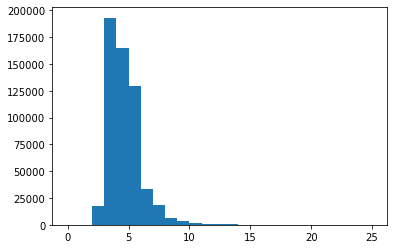

In [10]:
import matplotlib.pyplot as plt
plt.hist(df.iter,bins=range(0,max(df.iter)))
plt.savefig("Number of Dilations to reach annular points.png")